# How to use topic model by gensim

This document will show you how to use topic model by [gensim](https://radimrehurek.com/gensim/index.html).

The data for this tutorial is from [Recruit HotPepper Beauty API](http://webservice.recruit.co.jp/beauty/reference.html). So you need api key of it.

If you get api key, then execute below scripts.

* scripts/download_data.py
* scripts/make_corpus.py


```
python download_data.py your_api_key
```
It is for downloading the json data from api (extract hair salons data near the Tokyo).


```
python make_corpus path_to_downloaded_json_file
```

It is for making the corpus from json data. You can set some options to restrict the words in corpus. Please see the help of this script.

After executing above scripts, you will have corpus and dictionary in your `data` folder. 
Then, execute this notebook.

## Preparation

In [1]:
# enable showing matplotlib image inline
%matplotlib inline

# autoreload module
%load_ext autoreload
%autoreload 2

PROJECT_ROOT = "/"

def load_local_package():
    import os
    import sys
    root = os.path.join(os.getcwd(), "./")
    sys.path.append(root)  # load project root
    return root

PROJECT_ROOT = load_local_package()

## Load Corpus

In [79]:
prefix = "salons"

def load_corpus(p):
    import os
    from gensim import corpora
    
    d_path = os.path.join(PROJECT_ROOT, "./data/{0}_dict.dict".format(p))
    c_path = os.path.join(PROJECT_ROOT, "./data/{0}_corpus.mm".format(p))
    
    d = corpora.Dictionary.load(d_path)
    c = corpora.MmCorpus(c_path)
    
    return d, c

dictionary, corpus = load_corpus(prefix)

print(dictionary)
print(corpus)

Dictionary(19 unique tokens: ['ネイル', '着付け', '個室あり', '喫煙', 'ショッピングモール内にある']...)
MmCorpus(5202 documents, 19 features, 18755 non-zero entries)


## Make Topic Model

In [80]:
from gensim import models

topic_range = range(2, 5)
test_rate = 0.2

def split_corpus(c, rate_or_size):
    import math
    
    size = 0
    if isinstance(rate_or_size, float):
        size = math.floor(len(c) * rate_or_size)
    else:
        size = rate_or_size
    
    # simple split, not take sample randomly
    left = c[:-size]
    right = c[-size:]
    
    return left, right

def calc_perplexity(m, c):
    import numpy as np
    return np.exp(-m.log_perplexity(c))

def search_model(c, rate_or_size):
    most = [1.0e6, None]
    training, test = split(c, rate_or_size)
    print("dataset: training/test = {0}/{1}".format(len(training), len(test)))

    for t in topic_range:
        m = models.LdaModel(corpus=training, id2word=dictionary, num_topics=t, iterations=100, passes=5)
        p1 = calc_perplexity(m, training)
        p2 = calc_perplexity(m, test)
        print("{0}: perplexity is {1}/{2}".format(t, p1, p2))
        
        if p2 < most[0]:
            most[0] = p2
            most[1] = m
    
    return most[0], most[1]

perplexity, model = search_model(corpus, test_rate)
print("Best model: topics={0}, perplexity={0}".format(model.num_topics, perplexity))

dataset: training/test = 4162/1040
2: perplexity is 16.922533529928295/17.101513107684763
3: perplexity is 19.34028435170589/19.72322657199575
4: perplexity is 19.801127272166827/21.087860371868903
Best model: topics=2, perplexity=2


## Evaluate/Visualize Topic Model

### Check the distance between each topic

If we success to categorize the documents well, then the distance of each topic should be far apart.


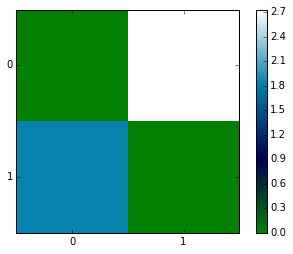

In [81]:
def calc_topic_distances(m, topic):
    import numpy as np
    
    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance
    
    # get probability of each words
    # https://github.com/piskvorky/gensim/blob/develop/gensim/models/ldamodel.py#L733

    t = m.state.get_lambda()
    for i, p in enumerate(t):
        t[i] = t[i] / t[i].sum()

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(m):
    import numpy as np
    import matplotlib.pylab as plt
    
    # make distance matrix
    mt = []
    for i in range(m.num_topics):
        d = calc_topic_distances(m, i)
        d.insert(i, (i, 0))  # distance between same topic
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)
    
    # plot matrix
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.show()

plot_distance_matrix(model)

### Check the topics in documents

If we success to categorize the documents well, each document has one mainly topic.


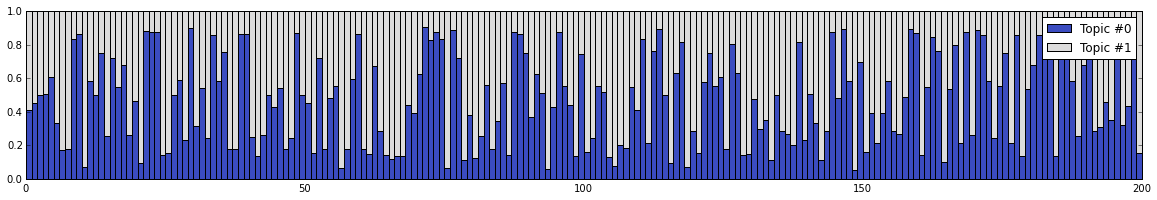

In [82]:
def show_document_topics(c, m, sample_size=200, width=1):
    import random
    import numpy as np
    import matplotlib.pylab as plt

    # make document/topics matrix
    document_topics = []
    samples = random.sample(range(len(c)), sample_size)
    for s in samples:
        ts = m.__getitem__(corpus[s], -1)
        document_topics.append([v[1] for v in ts])
    
    document_topics = np.array(document_topics)
    # draw cumulative bar chart
    fig = plt.figure(figsize=(20, 3))
    N, K = document_topics.shape
    indices = np.arange(N)
    height = np.zeros(N)
    bar = []
    for k in range(K):
        color = plt.cm.coolwarm(k / K, 1)
        p = plt.bar(indices, document_topics[:, k], width, bottom=None if k == 0 else height, color=color)
        height += document_topics[:, k]
        bar.append(p)
    
    plt.ylim((0, 1))
    plt.xlim((0, document_topics.shape[0]))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([b[0] for b in bar], topic_labels)
    plt.show(bar)

show_document_topics(corpus, model)


### Visualize words in topics

To consider about the name of topic, show the words in topics.


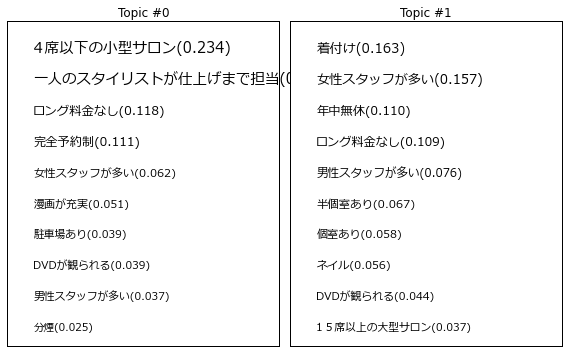

In [83]:
def visualize_topic(m, word_count=10, fontsize_base=10):
    import matplotlib.pylab as plt
    from matplotlib.font_manager import FontProperties
    font = lambda s: FontProperties(fname=r'C:\Windows\Fonts\meiryo.ttc', size=s)

    # get words in topic
    topic_words = []
    for t in range(m.num_topics):
        words = m.show_topic(t, topn=word_count)
        topic_words.append(words)
    
    # plot words
    fig = plt.figure(figsize=(8, 5))
    for i, ws in enumerate(topic_words):
        sub = fig.add_subplot(1, m.num_topics, i + 1)
        plt.ylim(0, word_count + 0.5)
        plt.xticks([])
        plt.yticks([])
        plt.title("Topic #{}".format(i))
        
        for j, (share, word) in enumerate(ws):
            size = fontsize_base + (fontsize_base * share * 2)
            w = "%s(%1.3f)" % (word, share)
            plt.text(0.1, word_count-j-0.5, w, ha="left", fontproperties=font(size))
    
    plt.tight_layout()
    plt.show()

visualize_topic(model)